In [94]:
import sys
sys.path.append("../..")
sys.path.append("../../..")

##### Import libary

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, fisher_exact
import utility, importlib
from scipy.stats import spearmanr
import pingouin as pg
from scipy.stats import linregress
import warnings
import kaos
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
pd.set_option('mode.chained_assignment', None)
import kaos
import pysam
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from sklearn.metrics import confusion_matrix
# import utility
import importlib
pd.set_option('mode.chained_assignment', None)

from pdf2image import convert_from_path
from PIL import Image
from IPython.display import display
# import r_boxplot_utils
import r_plot_utils
import kaos
import fcgr


In [96]:
kmer_length =10
fasta_file_path = "../../../data/GCF_000017985.1_ASM1798v1_genomic.fna"

In [97]:
def strip_whitespace_from_string_columns(input_df):
    """
    Returns a copy of the DataFrame with leading and trailing whitespace removed
    from all string/object columns.
    
    Args:
        input_df (pd.DataFrame): Input DataFrame to process.
    
    Returns:
        pd.DataFrame: Copy with whitespace stripped from all string columns.
    """
    cleaned_df = input_df.copy()
    for column in cleaned_df.select_dtypes(include=['object', 'string']):
        cleaned_df[column] = cleaned_df[column].str.strip()
    return cleaned_df

In [98]:
# LTEE_mutational_data

In [99]:
mutational_data_all_population = pd.read_csv("../../../data/LTEE_mutational_data.csv")
mutational_data_all_population = strip_whitespace_from_string_columns(mutational_data_all_population)


In [100]:
class Oligo:
    @staticmethod
    def kgain(mutational_data: pd.DataFrame, fasta_file_path: str, fasta_string: str, kmer_length: int) -> pd.DataFrame:
        """
        Compute k-mer log-gain for mutations using frequency dictionary from a genome FASTA.

        Args:
            mutational_data (pd.DataFrame): DataFrame with '#CHROM', 'POS', 'REF', 'ALT' columns.
            fasta_file_path (str): Path to the genome FASTA file.
            kmer_length (int): Length of k-mers to use (e.g., 10).

        Returns:
            pd.DataFrame: Result table with mutation context and kGain.
        """
        import numpy as np
        import pandas as pd
        import pysam
        import kaos

        mutational_data = mutational_data.copy()
        mutational_data.reset_index(inplace=True, drop=True)
        required_cols = ['#CHROM', 'POS', 'REF', 'ALT']
        missing = [col for col in required_cols if col not in mutational_data.columns]
        if missing:
            raise ValueError(
                f"Input DataFrame is missing required column(s): {', '.join(missing)}.\n"
                f"Columns found: {list(mutational_data.columns)}"
            )
        # Check for duplicates
        n_duplicates = mutational_data.duplicated(subset=required_cols).sum()
        if n_duplicates > 0:
            print(f"[Warning] Found {n_duplicates} duplicate mutation(s) in input DataFrame (by {required_cols}). Duplicates will be dropped.")
            mutational_data = mutational_data.drop_duplicates(subset=required_cols).reset_index(drop=True)

        flank_size = kmer_length - 1
        genome = pysam.FastaFile(fasta_file_path)
        
        fcgr_dict = kaos.chaos_frequency_dictionary(
            fasta_string=fasta_string,
            kmer_length=kmer_length,
            pseudo_count=True,
            chaos_game_kmer_array=kaos.chaos_game_representation_key(kmer_length=kmer_length)
        )
        # Strip whitespace from all non-numeric columns
        for col in mutational_data.select_dtypes(include=['object', 'string']):
            mutational_data[col] = mutational_data[col].str.strip()

        kmer_windows_result = []

        for i in range(mutational_data.shape[0]):
            try:
                chrom_id = mutational_data.loc[i, "#CHROM"]
                genome_pos = int(mutational_data.loc[i, "POS"])
                ref_allele = mutational_data.loc[i, "REF"]
                alt_allele = mutational_data.loc[i, "ALT"]

                assert isinstance(ref_allele, str) and len(ref_allele) == 1, f"Reference allele not a single base at row {i}"
                assert isinstance(alt_allele, str) and len(alt_allele) == 1, f"Alternate allele not a single base at row {i}"

                ref_flank_seq = genome.fetch(
                    chrom_id,
                    genome_pos - flank_size - 1,
                    genome_pos + flank_size
                )

                center_idx = kmer_length - 1
                if ref_flank_seq[center_idx] != ref_allele:
                    print(f"[Warning] Reference allele mismatch at row {i}: {ref_flank_seq[center_idx]} != {ref_allele} (CHROM={chrom_id}, POS={genome_pos})")
                    continue

                mutated_flank_seq = (
                    ref_flank_seq[:center_idx] + alt_allele + ref_flank_seq[center_idx+1:]
                )

                expected_len = 2 * flank_size + 1
                if len(ref_flank_seq) != expected_len or len(mutated_flank_seq) != expected_len:
                    print(f"[Warning] Skipping row {i} due to flank length mismatch: len(ref_flank_seq)={len(ref_flank_seq)}, len(mutated_flank_seq)={len(mutated_flank_seq)}, expected={expected_len}")
                    continue

                for j in range(kmer_length):
                    alt_window = mutated_flank_seq[center_idx - kmer_length + j + 1 : center_idx + 1 + j]
                    ref_window = ref_flank_seq[center_idx - kmer_length + j + 1 : center_idx + j + 1]

                    if len(alt_window) != kmer_length or len(ref_window) != kmer_length:
                        continue

                    try:
                        ratio = fcgr_dict[alt_window] / fcgr_dict[ref_window]
                        window_gain = np.log(ratio)
                    except KeyError as e:
                        print(f"[Warning] Missing k-mer in FCGR at row {i}, window {j}: {e}")
                        continue
                    except Exception as e:
                        print(f"[Error] Unexpected error at row {i}, window {j}: {e}")
                        continue

                    row = {
                        '#CHROM': chrom_id,
                        'POS': genome_pos,
                        "REF": ref_allele,
                        "ALT": alt_allele,
                        'ref_flank_seq': ref_flank_seq,
                        'mutated_flank_seq': mutated_flank_seq,
                        'altered_sliding_window': alt_window,
                        'reference_sliding_window': ref_window,
                        'window_number': j,
                        'window_gain': window_gain,
                    }
                    kmer_windows_result.append(row)

            except AssertionError as e:
                print(f"[Assertion Error] Row {i}: {e}")
            except Exception as e:
                print(f"[Exception] Row {i}: {e}")

        df_kmer_windows = pd.DataFrame(kmer_windows_result)

        # Final mutation-level summary (per-mutation, sum across all windows)
        mutation_kmer_gain_df = (
            df_kmer_windows
            .groupby(['#CHROM','POS', "REF", "ALT", 'ref_flank_seq', 'mutated_flank_seq'])["window_gain"]
            .sum()
            .reset_index()
            .rename(columns={"window_gain": "kGain"})
        )

        return mutation_kmer_gain_df
    

    @staticmethod
    def window_wise_kgain(mutational_data: pd.DataFrame, fasta_string: str, fasta_file_path: str, kmer_length: int) -> pd.DataFrame:
        """
        Compute k-mer log-gain for mutations using frequency dictionary from a genome FASTA.

        Args:
            mutational_data (pd.DataFrame): DataFrame with '#CHROM', 'POS', 'REF', 'ALT' columns.
            fasta_file_path (str): Path to the genome FASTA file.
            kmer_length (int): Length of k-mers to use (e.g., 10).

        Returns:
            pd.DataFrame: Result table with mutation context and window wise kGain.
        """
        import numpy as np
        import pandas as pd
        import pysam
        import kaos
        mutational_data = mutational_data.copy()
        mutational_data.reset_index(inplace=True, drop=True)
        required_cols = ['#CHROM', 'POS', 'REF', 'ALT']
        missing = [col for col in required_cols if col not in mutational_data.columns]
        if missing:
            raise ValueError(
                f"Input DataFrame is missing required column(s): {', '.join(missing)}.\n"
                f"Columns found: {list(mutational_data.columns)}"
            )
        # Check for duplicates
        n_duplicates = mutational_data.duplicated(subset=required_cols).sum()
        if n_duplicates > 0:
            print(f"[Warning] Found {n_duplicates} duplicate mutation(s) in input DataFrame (by {required_cols}). Duplicates will be dropped.")
            mutational_data = mutational_data.drop_duplicates(subset=required_cols).reset_index(drop=True)

        flank_size = kmer_length - 1
        genome = pysam.FastaFile(fasta_file_path)
        # fasta_string = kaos.read_fasta(fasta_file_path)
        fcgr_dict = kaos.chaos_frequency_dictionary(
            fasta_string=fasta_string,
            kmer_length=kmer_length,
            pseudo_count=True,
            chaos_game_kmer_array=kaos.chaos_game_representation_key(kmer_length=kmer_length)
        )
        # Strip whitespace from all non-numeric columns
        for col in mutational_data.select_dtypes(include=['object', 'string']):
            mutational_data[col] = mutational_data[col].str.strip()

        kmer_windows_result = []

        for i in range(mutational_data.shape[0]):
            try:
                chrom_id = mutational_data.loc[i, "#CHROM"]
                genome_pos = int(mutational_data.loc[i, "POS"])
                ref_allele = mutational_data.loc[i, "REF"]
                alt_allele = mutational_data.loc[i, "ALT"]

                assert isinstance(ref_allele, str) and len(ref_allele) == 1, f"Reference allele not a single base at row {i}"
                assert isinstance(alt_allele, str) and len(alt_allele) == 1, f"Alternate allele not a single base at row {i}"

                ref_flank_seq = genome.fetch(
                    chrom_id,
                    genome_pos - flank_size - 1,
                    genome_pos + flank_size
                )

                center_idx = kmer_length - 1
                if ref_flank_seq[center_idx] != ref_allele:
                    print(f"[Warning] Reference allele mismatch at row {i}: {ref_flank_seq[center_idx]} != {ref_allele} (CHROM={chrom_id}, POS={genome_pos})")
                    continue

                mutated_flank_seq = (
                    ref_flank_seq[:center_idx] + alt_allele + ref_flank_seq[center_idx+1:]
                )

                expected_len = 2 * flank_size + 1
                if len(ref_flank_seq) != expected_len or len(mutated_flank_seq) != expected_len:
                    print(f"[Warning] Skipping row {i} due to flank length mismatch: len(ref_flank_seq)={len(ref_flank_seq)}, len(mutated_flank_seq)={len(mutated_flank_seq)}, expected={expected_len}")
                    continue

                for j in range(kmer_length):
                    alt_window = mutated_flank_seq[center_idx - kmer_length + j + 1 : center_idx + 1 + j]
                    ref_window = ref_flank_seq[center_idx - kmer_length + j + 1 : center_idx + j + 1]

                    if len(alt_window) != kmer_length or len(ref_window) != kmer_length:
                        continue

                    try:
                        ratio = fcgr_dict[alt_window] / fcgr_dict[ref_window]
                        window_gain = np.log(ratio)
                    except KeyError as e:
                        print(f"[Warning] Missing k-mer in FCGR at row {i}, window {j}: {e}")
                        continue
                    except Exception as e:
                        print(f"[Error] Unexpected error at row {i}, window {j}: {e}")
                        continue

                    row = {
                        "chromosome_id": chrom_id,
                        'genome_position': genome_pos,
                        'reference_allele': ref_allele,
                        'alternate_allele': alt_allele,
                        'ref_flank_seq': ref_flank_seq,
                        'mutated_flank_seq': mutated_flank_seq,
                        'altered_sliding_window': alt_window,
                        'reference_sliding_window': ref_window,
                        'window_number': j,
                        'window_gain': window_gain,
                    }
                    kmer_windows_result.append(row)

            except AssertionError as e:
                print(f"[Assertion Error] Row {i}: {e}")
            except Exception as e:
                print(f"[Exception] Row {i}: {e}")

        df_kmer_windows = pd.DataFrame(kmer_windows_result)


        return df_kmer_windows


In [101]:
allele_counts_by_generation = pd.read_excel("../../../data/MetaData_ecoli_final.xlsx", sheet_name= "Mastersheet")
allele_counts_by_generation.drop_duplicates(subset=['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'], inplace=True)
allele_counts_by_generation.reset_index(inplace=True, drop=True)
allele_counts_by_generation.rename(columns={"CHROM": "#CHROM", "Position": "POS", "Ref_allele":"REF", "Alt_allele":"ALT", "label": "population_label"}, inplace=True)
allele_counts_by_generation['key'] = (
    allele_counts_by_generation['#CHROM'].astype(str) + '_' +
    allele_counts_by_generation['REF'] + '_' +
    allele_counts_by_generation['POS'].astype(str) + '_' +
    allele_counts_by_generation['ALT'] + '_' +
    allele_counts_by_generation['population_label'].astype(str)
)
allele_counts_by_generation =strip_whitespace_from_string_columns(allele_counts_by_generation)
allele_counts_by_generation.shape

(36922, 126)

In [102]:
allele_count_columns = [item for item in allele_counts_by_generation if item.startswith("AC")] ## Fiter the column starting with "AC" which indicate allele count
allele_count_columns.extend(['#CHROM','POS', 'Gene', 'Allele', 'Annotation', 'REF', 'ALT','population_label', 'key']) ##Add other relavent information
allele_counts_by_generation = allele_counts_by_generation[allele_count_columns]
print(allele_counts_by_generation.shape)

(36922, 126)


In [103]:
nan_columns = allele_counts_by_generation.columns[allele_counts_by_generation.isna().any()]
df_with_nan = allele_counts_by_generation[nan_columns]
nan_counts = allele_counts_by_generation.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print("\n Number of NaN values in each column:")
print(nan_counts)


 Number of NaN values in each column:
AC:2500      355
AC:15000    4953
AC:46500     331
AC:58000    3753
AC:58500     355
AC:59000     355
AC:59500     355
AC:60000     355
dtype: int64


In [104]:
allele_counts_by_generation.drop(nan_counts.index.tolist(), axis = 1, inplace=True)
allele_counts_by_generation.reset_index(inplace=True, drop = True)
allele_counts_by_generation.shape

(36922, 118)

In [105]:
ac_columns = [item for item in allele_counts_by_generation.columns if item.startswith('AC:')]

In [ ]:
# Make a working copy of the input DataFrame
allele_counts_per_generation = allele_counts_by_generation.copy()

# This DataFrame will store all per-mutation, per-generation, per-population records
long_format_mutation_counts = pd.DataFrame()

for generation_col in ac_columns:
    # Filter mutations where the allele count for this generation is nonzero
    nonzero_mutations = allele_counts_per_generation[allele_counts_per_generation[generation_col] != 0]

    # Select all relevant mutation and annotation information
    mutation_data = nonzero_mutations[['#CHROM', 'POS', 'Gene', 'REF', 'ALT', "population_label", "Annotation"]].copy()
    mutation_data['generation_label'] = generation_col
    mutation_data['allele_count'] = nonzero_mutations[generation_col]
    # If population_label is already included, this line is redundant, otherwise uncomment:
    # mutation_data['population_label'] = population

    # Append the records for this generation to the long-format DataFrame
    long_format_mutation_counts = pd.concat([long_format_mutation_counts, mutation_data], axis=0)

# Reset index after concatenation
long_format_mutation_counts.reset_index(inplace=True, drop=True)

# Extract the numeric generation (e.g., 'AC:1000' -> 1000)
long_format_mutation_counts['generation_number'] = (
    long_format_mutation_counts['generation_label'].str.extract(r'(\d+)').astype(int)
)
long_format_mutation_counts.drop("generation_label", axis=1, inplace=True)
long_format_mutation_counts.reset_index(inplace=True, drop=True)

long_format_mutation_counts['key'] = (
    long_format_mutation_counts['#CHROM'].astype(str) + '_' +
    long_format_mutation_counts['REF'] + '_' +
    long_format_mutation_counts['POS'].astype(str) + '_' +
    long_format_mutation_counts['ALT'] + '_' +
    long_format_mutation_counts['population_label'].astype(str) + '_' +
    long_format_mutation_counts['generation_number'].astype(str)
)



In [107]:
def mutate_fasta_by_generation(
    variant_data: pd.DataFrame,
    fasta_file_path: str,
    target_generation: int
) -> str:
    """
    Returns a mutated FASTA sequence for a specific generation, 
    substituting alternate alleles at given positions.

    Args:
        variant_data (pd.DataFrame): DataFrame with columns 
            ['#CHROM', 'POS', 'REF', 'ALT', 'generation_number'].
        fasta_file_path (str): Path to the reference genome FASTA file.
        target_generation (int): The generation number to apply mutations for.

    Returns:
        str: Mutated DNA sequence as a string.

    Raises:
        ValueError: If required columns are missing.
    """
    import kaos

    required_cols = ['#CHROM', 'POS', 'REF', 'ALT', 'generation_number']
    missing_cols = [col for col in required_cols if col not in variant_data.columns]
    if missing_cols:
        raise ValueError(
            f"Input DataFrame is missing required columns: {', '.join(missing_cols)}.\n"
            f"Columns found: {list(variant_data.columns)}"
        )

    variant_data = variant_data.copy()

    # Warn if duplicates are dropped
    before = variant_data.shape[0]
    variant_data = variant_data.drop_duplicates(subset=required_cols)
    after = variant_data.shape[0]
    if after < before:
        variant_data.drop_duplicates(inplace=True)
        variant_data.reset_index(inplace=True, drop=True)
        print(f"[Warning] Dropped {before - after} duplicate variant(s) based on columns {required_cols}.")

    # Read the reference sequence from FASTA
    reference_seq = kaos.read_fasta(fasta_file_path)

    # Filter mutations for the target generation
    relevant_variants = variant_data[variant_data["generation_number"] == target_generation]

    mutated_seq = list(reference_seq)
    for pos, alt_allele in zip(relevant_variants["POS"].astype(int), relevant_variants["ALT"]):
        seq_index = pos - 1  # 1-based to 0-based
        if 0 <= seq_index < len(mutated_seq):
            mutated_seq[seq_index] = alt_allele

    return ''.join(mutated_seq)


In [108]:
ref_fasta_string = kaos.read_fasta(fasta_file_path)

In [109]:
kgain_all_population_evolved = pd.DataFrame()

target_generation = 57500

dct_fasta_pop_wise_target_generation_57500 = dict()
for population in set(long_format_mutation_counts["population_label"]):

    individual_population_wise_mutation_counts, individual_population_wise_mutation_counts_for_selected_generation = [None] * 2

    individual_population_wise_mutation_counts = long_format_mutation_counts[long_format_mutation_counts["population_label"]==population]
    individual_population_wise_mutation_counts_for_selected_generation = individual_population_wise_mutation_counts[individual_population_wise_mutation_counts["generation_number"]==target_generation]
    individual_population_wise_mutation_counts_for_selected_generation.reset_index(inplace=True, drop=True)
    dct_fasta_pop_wise_target_generation_57500[population] = mutate_fasta_by_generation(variant_data = individual_population_wise_mutation_counts_for_selected_generation, fasta_file_path = fasta_file_path, target_generation=target_generation)
    

for population in set(mutational_data_all_population["population_label"]):
    pop_wise_mutational_data, kgain_individual_population, fasta_individual_population, fasta_string = [None] * 4
    fasta_individual_population = fasta_file_path
    fasta_string = dct_fasta_pop_wise_target_generation_57500[population]
    pop_wise_mutational_data = mutational_data_all_population[mutational_data_all_population["population_label"]==population][['#CHROM', 'POS', 'REF', 'ALT']]
    kgain_individual_population = Oligo.kgain(mutational_data = pop_wise_mutational_data, fasta_string = fasta_string, fasta_file_path =fasta_file_path, kmer_length=kmer_length)
    kgain_individual_population["population_label"] = population
    kgain_all_population_evolved = pd.concat([kgain_all_population_evolved, kgain_individual_population])
kgain_all_population_evolved.reset_index(inplace=True, drop=True)
kgain_all_population_evolved.rename(columns={"kGain": "evolved_kGain"}, inplace=True)


In [ ]:
kgain_all_population_evolved['key'] = (
    kgain_all_population_evolved['#CHROM'].astype(str) + '_' +
    kgain_all_population_evolved['REF'] + '_' +
    kgain_all_population_evolved['POS'].astype(str) + '_' +
    kgain_all_population_evolved['ALT'] + '_' +
    kgain_all_population_evolved['population_label'].astype(str)
)

In [111]:
kgain_all_population_evolved.shape

(36922, 9)

In [112]:
kgain_all_population_evolved.head()

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,evolved_kGain,population_label,key
0,NC_012967.1,1335,C,T,ATGGCGGCGCGCGTGTTTG,ATGGCGGCGTGCGTGTTTG,-4.424538,p4,NC_012967.1_C_1335_T_p4
1,NC_012967.1,1740,T,G,ATCGAAGTGTTTGTGATTG,ATCGAAGTGGTTGTGATTG,-3.775891,p4,NC_012967.1_T_1740_G_p4
2,NC_012967.1,4553,A,C,CTGCGACCAACGTGAACGA,CTGCGACCACCGTGAACGA,-0.398158,p4,NC_012967.1_A_4553_C_p4
3,NC_012967.1,10562,C,A,TTTTCAGGGCGCGGCATAA,TTTTCAGGGAGCGGCATAA,-10.544842,p4,NC_012967.1_C_10562_A_p4
4,NC_012967.1,10563,G,A,TTTCAGGGCGCGGCATAAT,TTTCAGGGCACGGCATAAT,-7.538027,p4,NC_012967.1_G_10563_A_p4


In [113]:
kgain_all_population_wt = pd.DataFrame()

for population in set(mutational_data_all_population["population_label"]):
    pop_wise_mutational_data, kgain_individual_population, fasta_individual_population, fasta_string = [None] * 4
    fasta_individual_population = fasta_file_path
    fasta_string = kaos.read_fasta(fasta_file_path)
    pop_wise_mutational_data = mutational_data_all_population[mutational_data_all_population["population_label"]==population][['#CHROM', 'POS', 'REF', 'ALT']]
    kgain_individual_population = Oligo.kgain(mutational_data = pop_wise_mutational_data, fasta_string = fasta_string, fasta_file_path =fasta_file_path, kmer_length=kmer_length)
    kgain_individual_population["population_label"] = population
    kgain_all_population_wt = pd.concat([kgain_all_population_wt, kgain_individual_population])

kgain_all_population_wt.reset_index(inplace=True, drop=True)
kgain_all_population_wt.rename(columns={"kGain": "wild_type_kGain"}, inplace=True)


In [114]:
kgain_all_population_wt.head()

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,wild_type_kGain,population_label
0,NC_012967.1,1335,C,T,ATGGCGGCGCGCGTGTTTG,ATGGCGGCGTGCGTGTTTG,-7.350176,p4
1,NC_012967.1,1740,T,G,ATCGAAGTGTTTGTGATTG,ATCGAAGTGGTTGTGATTG,-3.775891,p4
2,NC_012967.1,4553,A,C,CTGCGACCAACGTGAACGA,CTGCGACCACCGTGAACGA,-0.398158,p4
3,NC_012967.1,10562,C,A,TTTTCAGGGCGCGGCATAA,TTTTCAGGGAGCGGCATAA,-10.544842,p4
4,NC_012967.1,10563,G,A,TTTCAGGGCGCGGCATAAT,TTTCAGGGCACGGCATAAT,-7.538027,p4


In [115]:
mutator_list = ['m1', 'm2', 'm3', 'm4', 'p3', 'p6']
non_mutator_list = ['p1', 'p2', 'p4', 'p5', 'm5', 'm6']

In [116]:
def classify_mutator_type(pop_label):
    if pop_label in mutator_list:
        return "mutator"
    elif pop_label in non_mutator_list:
        return "non_mutator"
    else:
        return np.nan  # or "other" if you want a default
    
long_format_mutation_counts["mutator_type"] = long_format_mutation_counts["population_label"].apply(classify_mutator_type)
long_format_mutation_counts.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator


In [117]:
kgain_all_population_wt["#CHROM"]  = "chrI"
kgain_all_population_evolved["#CHROM"]  = "chrI"

In [118]:
# create new key col with some cols
kgain_all_population_evolved['unique_mutation_key'] = (
    kgain_all_population_evolved['#CHROM'].astype(str) + '_' +
    
    kgain_all_population_evolved['REF'] + '_' +
    kgain_all_population_evolved['POS'].astype(str) + '_' +
    kgain_all_population_evolved['ALT'] + '_' +
    kgain_all_population_evolved['population_label'].astype(str)
)

kgain_all_population_wt['unique_mutation_key'] = (
    kgain_all_population_wt['#CHROM'].astype(str) + '_' +
    kgain_all_population_wt['REF'] + '_' +
    kgain_all_population_wt['POS'].astype(str) + '_' +
    kgain_all_population_wt['ALT'] + '_' +
    kgain_all_population_wt['population_label'].astype(str)
    # long_format_mutation_counts['generation_number'].astype(str)
)

In [119]:
kgain_all_population_wt =strip_whitespace_from_string_columns(kgain_all_population_wt)
long_format_mutation_counts =strip_whitespace_from_string_columns(long_format_mutation_counts)
kgain_all_population_evolved =strip_whitespace_from_string_columns(kgain_all_population_evolved)


In [120]:
kgain_all_population_wt

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,wild_type_kGain,population_label,unique_mutation_key
0,chrI,1335,C,T,ATGGCGGCGCGCGTGTTTG,ATGGCGGCGTGCGTGTTTG,-7.350176,p4,chrI_C_1335_T_p4
1,chrI,1740,T,G,ATCGAAGTGTTTGTGATTG,ATCGAAGTGGTTGTGATTG,-3.775891,p4,chrI_T_1740_G_p4
2,chrI,4553,A,C,CTGCGACCAACGTGAACGA,CTGCGACCACCGTGAACGA,-0.398158,p4,chrI_A_4553_C_p4
3,chrI,10562,C,A,TTTTCAGGGCGCGGCATAA,TTTTCAGGGAGCGGCATAA,-10.544842,p4,chrI_C_10562_A_p4
4,chrI,10563,G,A,TTTCAGGGCGCGGCATAAT,TTTCAGGGCACGGCATAAT,-7.538027,p4,chrI_G_10563_A_p4
...,...,...,...,...,...,...,...,...,...
36917,chrI,4626353,C,A,AAATCCCCCCTGTTCTGGA,AAATCCCCCATGTTCTGGA,-1.883567,m3,chrI_C_4626353_A_m3
36918,chrI,4626487,C,T,AAGTACCAGCGGGCCGCAA,AAGTACCAGTGGGCCGCAA,-7.947944,m3,chrI_C_4626487_T_m3
36919,chrI,4628349,G,A,GGATCTGATGCATTTCCGC,GGATCTGATACATTTCCGC,-6.463051,m3,chrI_G_4628349_A_m3
36920,chrI,4628770,C,T,CAATTGTAGCACGTTAACA,CAATTGTAGTACGTTAACA,-5.142313,m3,chrI_C_4628770_T_m3


In [121]:
merged_mutation_metrics_wt = pd.merge(long_format_mutation_counts, kgain_all_population_wt)
merged_mutation_metrics_wt =strip_whitespace_from_string_columns(merged_mutation_metrics_wt)
merged_mutation_metrics_wt.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,unique_mutation_key
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,chrI_C_73002_T_p1
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,chrI_C_144449_T_p1
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,chrI_G_524856_A_p1
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,chrI_C_557008_T_p1


In [122]:
merged_mutation_metrics_evolved = pd.merge(long_format_mutation_counts, kgain_all_population_evolved.drop(["key"], axis=1))
merged_mutation_metrics_evolved =strip_whitespace_from_string_columns(merged_mutation_metrics_evolved)
# merged_mutation_metrics_evolved.rename(columns={"kGain": "evolved_kGain"}, inplace=True)
merged_mutation_metrics_evolved.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,evolved_kGain,unique_mutation_key
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,chrI_C_73002_T_p1
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,chrI_C_144449_T_p1
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-0.911021,chrI_G_524856_A_p1
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,chrI_C_557008_T_p1


In [123]:
def classify_coding_type(annotation):
    if annotation in ['noncoding']:
        return "noncoding"
    elif annotation not in ['noncoding']:
        return "coding"
    else:
        return np.nan  # or "other" if you want a default

In [124]:
merged_mutation_metrics_wt["coding_type"] = merged_mutation_metrics_wt["Annotation"].apply(classify_coding_type)
merged_mutation_metrics_wt.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,unique_mutation_key,coding_type
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,chrI_C_73002_T_p1,noncoding
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,chrI_C_144449_T_p1,coding
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1,coding
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,chrI_G_524856_A_p1,coding
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,chrI_C_557008_T_p1,coding


In [125]:
merged_mutation_metrics_wt_evolved = pd.merge(merged_mutation_metrics_wt, merged_mutation_metrics_evolved)
merged_mutation_metrics_wt_evolved.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,unique_mutation_key,coding_type,evolved_kGain
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,chrI_C_73002_T_p1,noncoding,-8.947374
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,chrI_C_144449_T_p1,coding,-8.688648
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,chrI_C_458736_T_p1,coding,-6.869305
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,chrI_G_524856_A_p1,coding,-0.911021
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,chrI_C_557008_T_p1,coding,-7.751139


In [126]:
# df_essential_gene = pd.read_excel("../../../data/gene type.xlsx")
# Read the essential gene information from Excel
essential_genes_df = pd.read_excel("/home/abhishekh/Downloads/Oligo_Promotion-main(8) (1)/Oligo_Promotion-main/data/gene type.xlsx")
# Remove rows where 'Gene' is missing
essential_genes_df.dropna(subset=["Gene"], inplace=True)
# Reset index after dropping rows
essential_genes_df.reset_index(inplace=True, drop=True)
# Trim whitespace from gene names (string fields)
essential_genes_df["Gene"] = essential_genes_df["Gene"].str.strip()
# Remove whitespace from all string columns (good practice)
essential_genes_df = strip_whitespace_from_string_columns(essential_genes_df)
essential_genes_df.columns = ["Gene", "essentiality_status"]
# Preview
essential_genes_df.head()


,Gene,essentiality_status
0,thrL,non-essential
1,thrA,non-essential
2,thrB,non-essential
3,thrC,non-essential
4,yaaX,non-essential


In [127]:
kgain_mutations_merged = pd.merge(
    kgain_all_population_evolved,
    allele_counts_by_generation[['#CHROM', 'POS', "Gene", "REF", "ALT", "population_label", "Annotation"]].drop_duplicates()
)
kgain_mutations_annotated = pd.merge(
    kgain_mutations_merged,
    essential_genes_df,
    how="left"
)
# kgain_mutations_annotated["synonymous_type"] = kgain_mutations_annotated["Annotation"].apply(classify_coding_type_synonymous)
kgain_mutations_annotated["coding_type"] = kgain_mutations_annotated["Annotation"].apply(classify_coding_type)

kgain_mutations_annotated["mutator_type"] = kgain_mutations_annotated["population_label"].apply(classify_mutator_type)


In [129]:
kgain_mutations_annotated

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,evolved_kGain,population_label,key,unique_mutation_key,Gene,Annotation,essentiality_status,coding_type,mutator_type
0,chrI,1335,C,T,ATGGCGGCGCGCGTGTTTG,ATGGCGGCGTGCGTGTTTG,-4.424538,p4,NC_012967.1_C_1335_T_p4,chrI_C_1335_T_p4,thrA,missense,non-essential,coding,non_mutator
1,chrI,1740,T,G,ATCGAAGTGTTTGTGATTG,ATCGAAGTGGTTGTGATTG,-3.775891,p4,NC_012967.1_T_1740_G_p4,chrI_T_1740_G_p4,thrA,missense,non-essential,coding,non_mutator
2,chrI,4553,A,C,CTGCGACCAACGTGAACGA,CTGCGACCACCGTGAACGA,-0.398158,p4,NC_012967.1_A_4553_C_p4,chrI_A_4553_C_p4,thrC,missense,non-essential,coding,non_mutator
3,chrI,10562,C,A,TTTTCAGGGCGCGGCATAA,TTTTCAGGGAGCGGCATAA,-10.544842,p4,NC_012967.1_C_10562_A_p4,chrI_C_10562_A_p4,yaaH,noncoding,non-essential,noncoding,non_mutator
4,chrI,10563,G,A,TTTCAGGGCGCGGCATAAT,TTTCAGGGCACGGCATAAT,-7.538027,p4,NC_012967.1_G_10563_A_p4,chrI_G_10563_A_p4,yaaH,noncoding,non-essential,noncoding,non_mutator
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36917,chrI,4626353,C,A,AAATCCCCCCTGTTCTGGA,AAATCCCCCATGTTCTGGA,3.276034,m3,NC_012967.1_C_4626353_A_m3,chrI_C_4626353_A_m3,intergenic,noncoding,NaN,noncoding,mutator
36918,chrI,4626487,C,T,AAGTACCAGCGGGCCGCAA,AAGTACCAGTGGGCCGCAA,-4.745293,m3,NC_012967.1_C_4626487_T_m3,chrI_C_4626487_T_m3,intergenic,noncoding,NaN,noncoding,mutator
36919,chrI,4628349,G,A,GGATCTGATGCATTTCCGC,GGATCTGATACATTTCCGC,-6.463051,m3,NC_012967.1_G_4628349_A_m3,chrI_G_4628349_A_m3,arcA,missense,non-essential,coding,mutator
36920,chrI,4628770,C,T,CAATTGTAGCACGTTAACA,CAATTGTAGTACGTTAACA,-5.142313,m3,NC_012967.1_C_4628770_T_m3,chrI_C_4628770_T_m3,intergenic,noncoding,NaN,noncoding,mutator


In [ ]:
# Merge mutation metrics with gene essentiality annotation
mutation_with_essentiality_df = pd.merge(
    merged_mutation_metrics_wt_evolved, 
    essential_genes_df, 
    how="left"
)



In [132]:
AC_DC = pd.read_csv("../../../data/concat_pop_annotation.csv")
# Drop cols having the string Unnamed
AC_DC = AC_DC.loc[:, ~AC_DC.columns.str.contains('Unnamed')]
# strip white spaces from all cols in AC_DC df
AC_DC.columns = AC_DC.columns.str.strip()
# strip white spaces from all rows in df AC_DC
AC_DC = AC_DC.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
AC_DC[['REF', 'ALT']] = AC_DC['Allele'].str.split('->', expand=True)
AC_DC.rename(columns={"Position":"POS", "label":"population_label"}, inplace=True)
AC_DC.drop_duplicates(subset=["POS", "population_label", "Gene", "REF", "ALT"], inplace=True)
AC_DC.reset_index(inplace=True, drop=True)
AC_DC

,POS,Gene,Allele,Annotation,Test.statistic,P-value,Deletion.index,Fold.reduction,Deletion.P-value,Duplication.index,...,DP:1040099,AC:1050000,DP:1050000,AC:1050100,DP:1050100,Ref_allele,Alt_allele,population_label,REF,ALT
0,1554,thrA,C->A,missense,0.000000,1.0000,116,-1.62360,0.003545,115,...,44,0,79,0,51,C,A,p1,C,A
1,1556,thrA,C->A,synonymous,0.000000,1.0000,116,-1.62633,0.005224,115,...,44,0,79,0,51,C,A,p1,C,A
2,2450,thrA,G->T,synonymous,1.438970,0.0001,116,-1.00000,0.053812,116,...,27,113,113,66,66,G,T,p1,G,T
3,4274,thrC,C->T,missense,0.000000,1.0000,116,-1.00000,0.011331,113,...,39,0,110,0,49,C,T,p1,C,T
4,6400,yaaA,T->G,missense,0.000000,1.0000,116,-1.00000,0.037267,113,...,42,0,126,0,67,T,G,p1,T,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36917,4509212,sgcC,C->T,synonymous,0.000000,1.0000,120,-1.00000,0.292683,118,...,150,0,246,0,55,C,T,m6,C,T
36918,4532106,gntP,C->T,synonymous,0.000000,1.0000,120,-1.00000,0.521739,119,...,107,1,244,0,74,C,T,m6,C,T
36919,4533490,uxuA,C->T,missense,0.000000,1.0000,120,-1.00000,0.705882,119,...,168,0,243,0,81,C,T,m6,C,T
36920,4606154,yjjI,C->T,missense,0.000000,1.0000,120,-1.00000,0.179104,119,...,116,0,249,0,64,C,T,m6,C,T


In [133]:
# 1) Identify your identifier columns vs AC/DP columns
id_cols = [c for c in AC_DC.columns if not (c.startswith("AC:") or c.startswith("DP:"))]
ac_cols = [c for c in AC_DC.columns if c.startswith("AC:")]
dp_cols = [c for c in AC_DC.columns if c.startswith("DP:")]

# 2) Stack the AC columns
df_ac = (
    AC_DC
    .set_index(id_cols)[ac_cols]
    # drop the "AC:" prefix to just leave the sample id
    .rename(columns=lambda c: c.split(":",1)[1])
    .stack()
    .reset_index()
    .rename(columns={"level_"+str(len(id_cols)): "generation_number", 0: "AC"})
)

# 3) Stack the DP columns the same way
df_dp = (
    AC_DC
    .set_index(id_cols)[dp_cols]
    .rename(columns=lambda c: c.split(":",1)[1])
    .stack()
    .reset_index()
    .rename(columns={"level_"+str(len(id_cols)): "generation_number", 0: "DP"})
)

# 4) Merge them back together on the ids + sample
long_df = pd.merge(df_ac, df_dp, on=id_cols + ["generation_number"])

long_df['allele_freq'] = np.where(long_df['DP'] > 0, long_df['AC'] / long_df['DP'], np.nan)
long_df["generation_number"] = long_df["generation_number"].astype(int)
mutation_with_essentiality_df_with_allele_frequency = pd.merge(mutation_with_essentiality_df, long_df, on = ["POS", "population_label", "Gene", "REF", "ALT", "generation_number", "Annotation"])
mutation_with_essentiality_df_with_allele_frequency['key'] = (
    mutation_with_essentiality_df_with_allele_frequency['#CHROM'].astype(str) + '_' +
    mutation_with_essentiality_df_with_allele_frequency['REF'] + '_' +
    mutation_with_essentiality_df_with_allele_frequency['POS'].astype(str) + '_' +
    mutation_with_essentiality_df_with_allele_frequency['ALT'] + '_' + 
    mutation_with_essentiality_df_with_allele_frequency['population_label'].astype(str) + '_' +
    mutation_with_essentiality_df_with_allele_frequency['generation_number'].astype(str)
)

mutation_with_essentiality_df_with_allele_frequency["unique_mutation_key"] =  (
    mutation_with_essentiality_df_with_allele_frequency['#CHROM'].astype(str) + '_' +
    mutation_with_essentiality_df_with_allele_frequency['REF'] + '_' +
    mutation_with_essentiality_df_with_allele_frequency['POS'].astype(str) + '_' +
    mutation_with_essentiality_df_with_allele_frequency['ALT'] + '_' + 
    mutation_with_essentiality_df_with_allele_frequency['population_label'].astype(str)
    # mut_allele_freq_df['generation_number'].astype(str)
)

In [134]:
mutation_with_essentiality_df_with_allele_frequency = pd.merge(mutation_with_essentiality_df, long_df, on = ["POS", "population_label", "Gene", "REF", "ALT", "generation_number", "Annotation"])

In [135]:
# mutation_with_essentiality_df_with_allele_frequency

In [ ]:
def classify_fixation_per_label(df, freq_threshold=0.95, min_last_points=2):
    result = []
    c = 0
    d = 0
    for label, group in df.groupby('unique_mutation_key'):
        
        group_sorted = group.sort_values('generation_number')

        last_gen = group_sorted['generation_number'].tail(min_last_points)
        last_freqs = group_sorted['allele_freq'].tail(min_last_points)
        status = 'fixed' if (last_freqs >= freq_threshold).all() else 'not_fixed'
        result.append({'unique_mutation_key': label, 'fixation_status': status})

    return pd.DataFrame(result)

# Run and merge back into the original DataFrame
fixation_df = classify_fixation_per_label(mutation_with_essentiality_df_with_allele_frequency[["unique_mutation_key", "generation_number", 'allele_freq']])
fixation_df.head()
# final2 = final2.merge(fixation_df, on='key')

,unique_mutation_key,fixation_status
0,chrI_A_1000475_G_p3,not_fixed
1,chrI_A_1000488_C_p6,not_fixed
2,chrI_A_1000506_C_p6,not_fixed
3,chrI_A_1001043_G_m2,fixed
4,chrI_A_1001295_G_m3,fixed


In [137]:
# --- Preprocess allele frequency ---
eps = 1e-4
mut_allele_freq_df = mutation_with_essentiality_df_with_allele_frequency.copy()
mut_allele_freq_df['allele_freq'] = mut_allele_freq_df['allele_freq'].clip(eps, 1 - eps)
mut_allele_freq_df['logit'] = np.log(mut_allele_freq_df['allele_freq'] / (1 - mut_allele_freq_df['allele_freq']))
mut_allele_freq_df["unique_mutation_key"] =  (
    mut_allele_freq_df['#CHROM'].astype(str) + '_' +
    mut_allele_freq_df['REF'] + '_' +
    mut_allele_freq_df['POS'].astype(str) + '_' +
    mut_allele_freq_df['ALT'] + '_' + 
    mut_allele_freq_df['population_label'].astype(str)
    # mut_allele_freq_df['generation_number'].astype(str)
)

In [138]:
from scipy import stats
from statsmodels.stats.multitest import multipletests


def regression(group):
    if group['generation_number'].nunique() < 10:
        return pd.Series({'s_est': np.nan, 'stderr': np.nan, 'p_raw': np.nan})
    x = group['generation_number']
    y = group['logit']
    slope, intercept, r, p, stderr = stats.linregress(x, y)
    return pd.Series({'s_est': slope, 'stderr': stderr, 'p_raw': p})


regression_results_df = (
    mut_allele_freq_df
    .groupby(['unique_mutation_key'], sort=False)
    .apply(regression)
    .reset_index()
)

# results1 = mutation_with_essentiality_df_with_allele_frequency.groupby(['key', 'population_label'], sort=False).apply(regression).reset_index()

# Initialize column with NaN
regression_results_df['p_adj'] = np.nan

# Mask for valid p-values
mask = regression_results_df['p_raw'].notna()

# Apply FDR correction only to valid values
regression_results_df.loc[mask, 'p_adj'] = multipletests(regression_results_df.loc[mask, 'p_raw'], method='fdr_bh')[1]

def classify_selection(row):
    # Treat insufficient data as neutral
    if np.isnan(row['p_adj']):
        return 'neutral'
    if row['p_adj'] < 0.05:
        return 'positive' if row['s_est'] > 0 else 'negative'
    return 'neutral'
    

# regression_results_df['classification'] = "unknown"
regression_results_df['classification'] = regression_results_df.apply(classify_selection, axis=1)
regression_results_df  = strip_whitespace_from_string_columns(regression_results_df)
kgain_all_population_evolved  = strip_whitespace_from_string_columns(kgain_all_population_evolved)

annotated_mutations_df  = pd.merge(kgain_all_population_evolved, regression_results_df[['unique_mutation_key', 'classification']], on='unique_mutation_key', how='left')
annotated_mutations_df  = strip_whitespace_from_string_columns(annotated_mutations_df)
annotated_mutations_df.head()


/tmp/ipykernel_99464/989729584.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(regression)


,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,evolved_kGain,population_label,key,unique_mutation_key,classification
0,chrI,1335,C,T,ATGGCGGCGCGCGTGTTTG,ATGGCGGCGTGCGTGTTTG,-4.424538,p4,NC_012967.1_C_1335_T_p4,chrI_C_1335_T_p4,positive
1,chrI,1740,T,G,ATCGAAGTGTTTGTGATTG,ATCGAAGTGGTTGTGATTG,-3.775891,p4,NC_012967.1_T_1740_G_p4,chrI_T_1740_G_p4,neutral
2,chrI,4553,A,C,CTGCGACCAACGTGAACGA,CTGCGACCACCGTGAACGA,-0.398158,p4,NC_012967.1_A_4553_C_p4,chrI_A_4553_C_p4,neutral
3,chrI,10562,C,A,TTTTCAGGGCGCGGCATAA,TTTTCAGGGAGCGGCATAA,-10.544842,p4,NC_012967.1_C_10562_A_p4,chrI_C_10562_A_p4,neutral
4,chrI,10563,G,A,TTTCAGGGCGCGGCATAAT,TTTCAGGGCACGGCATAAT,-7.538027,p4,NC_012967.1_G_10563_A_p4,chrI_G_10563_A_p4,neutral


In [139]:
annotated_mutations_df["mutator_type"] = annotated_mutations_df["population_label"].apply(classify_mutator_type)


In [140]:
# fixation_df["fixation_status"].value_counts().reset_index()

##### Fig. 2e

In [141]:
annotated_mutations_df["classification"].value_counts().reset_index()

,classification,count
0,neutral,23086
1,positive,9424
2,negative,4330


##### Fig. 2f

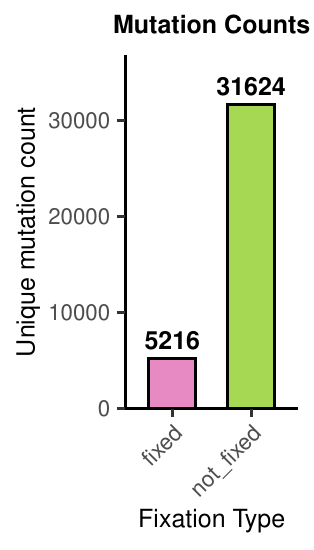

In [142]:
# r_boxplot_utils.plot_custom_bar_r(df=kgain_all_population_evolved["mutator_type"].value_counts().reset_index(), x_column = "mutator_type", y_column="count")

pdf_file="number_of_unique_mutation_count_vs_fixation_type.pdf"
r_plot_utils.plot_custom_bar_r(
    df=fixation_df["fixation_status"].value_counts().reset_index(),
    x_column="fixation_status",
    y_column="count",
    fill_column="fixation_status",
    fill_colors=['#e78ac3', '#a6d854'],
    x_label="Fixation Type",
    y_label="Unique mutation count",
    plot_title="Mutation Counts",
    y_limits=[0, 35000],
    pdf_width=4, pdf_height=7, units="cm",
    legend_position = (10,10),
    font_size_title=9,
    pdf_file=pdf_file
)

pages = convert_from_path(pdf_file, dpi=200)
display(pages[0])  # Show the first page as an image




##### Fig. 2g

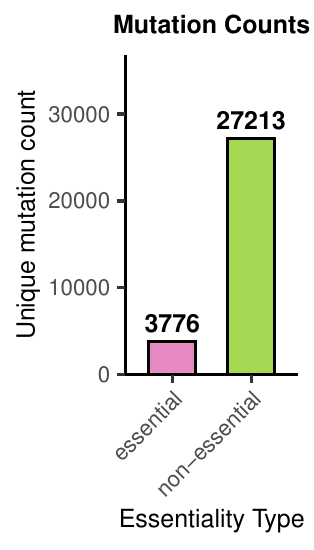

In [143]:
# r_boxplot_utils.plot_custom_bar_r(df=kgain_all_population_evolved["mutator_type"].value_counts().reset_index(), x_column = "mutator_type", y_column="count")

pdf_file="number_of_unique_mutation_count_vs_essentiality_type.pdf"
r_plot_utils.plot_custom_bar_r(
    df=kgain_mutations_annotated["essentiality_status"].value_counts().reset_index(),
    x_column="essentiality_status",
    y_column="count",
    fill_column="essentiality_status",
    fill_colors=['#e78ac3', '#a6d854'],
    x_label="Essentiality Type",
    y_label="Unique mutation count",
    plot_title="Mutation Counts",
    y_limits=[0, 35000],
    pdf_width=4, pdf_height=7, units="cm",
    legend_position = (10,10),
    font_size_title=9,
    pdf_file=pdf_file
)

pages = convert_from_path(pdf_file, dpi=200)
display(pages[0])  # Show the first page as an image




##### Fig. 2h

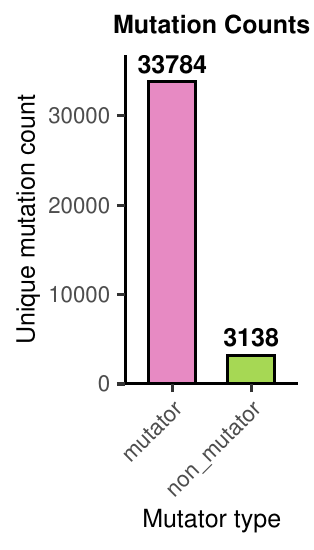

In [144]:
# r_boxplot_utils.plot_custom_bar_r(df=kgain_all_population_evolved["mutator_type"].value_counts().reset_index(), x_column = "mutator_type", y_column="count")

pdf_file="number_of_unique_mutation_count_vs_mutator_type.pdf"
r_plot_utils.plot_custom_bar_r(
    df=kgain_mutations_annotated["mutator_type"].value_counts().reset_index(),
    x_column="mutator_type",
    y_column="count",
    fill_column="mutator_type",
    fill_colors=['#e78ac3', '#a6d854'],
    x_label="Mutator type",
    y_label="Unique mutation count",
    plot_title="Mutation Counts",
    y_limits=[0, 35000],
    pdf_width=4, pdf_height=7, units="cm",
    legend_position = (10,10),
    font_size_title=9,
    pdf_file=pdf_file
)

pages = convert_from_path(pdf_file, dpi=200)
display(pages[0])  # Show the first page as an image




##### Fig. 2i

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


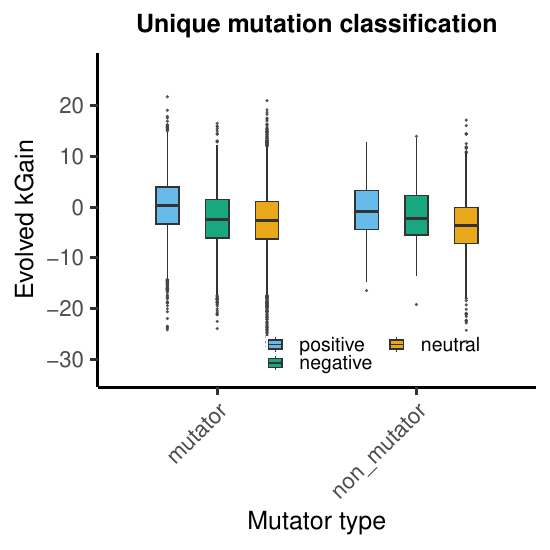

In [145]:

pdf_file = "Ecoli evolved kGain vs mutator type with mutation type as hue.pdf"
r_plot_utils.plot_grouped_violinboxplot_r(
    annotated_mutations_df[["mutator_type", "evolved_kGain", "classification"]].dropna(),
    fill_colors=["#56B4E9", "#009E73", "#E69F00"], point_colors=["#56B4E9", "#009E73", "#E69F00"],
    legend_position=[0.35, 0.0],
    y_limits=[-30, 25], y_breaks=list(range(-30, 25, 10)),
    show_pvalue=True, show_signif=True,
    pvalue_text_size=2,
    xtick_rotation=45,
    # box_width=0.5, box_linewidth=0.25, median_linewidth=0.5,outlier_color="blue",
    # outlier_shape=21,
    pvalue_y_npc=0.95, signif_y_npc=0.98,
    font_size_title=9, font_size_xlabel=9, font_size_ylabel=9, font_size_xtick=8, font_size_ytick=8, font_size_legend=7, font_size_annotation=2,
    x_column="mutator_type", y_column="evolved_kGain",
    alternative = "less",
    hue_column="classification",
    plot_title="Unique mutation classification", x_label="Mutator type", y_label="Evolved kGain",
    reference_level="positive",
    # font_size_annotation=2,
    pdf_file=pdf_file,
    pdf_width=7, pdf_height=7, pdf_dpi=600,
    show_points=False,
    
    dodge_width=0.75,
    violin_width = 0.7,
    violin_linewidth = 0.25,
    box_width = 0.35,
    box_linewidth = 0.25,
    outlier_shape = 16,
    outlier_color = "#444444",
    outlier_size = 0.25,
    # median_linewidth = 1

)


pages = convert_from_path(pdf_file, dpi=200)
display(pages[0])  # Show the first page as an image


P-value = 2.97e-17 and and effect size = 7.57e-01 for positive vs neutral in non_mutator
P-value = 3.03e-02 and and effect size = 3.75e-01 for positive vs negative in non_mutator
P-value = 5.56e-06 and and effect size = 3.70e-01 for negative vs neutral in non_mutator
P-value = 0.00e+00 and and effect size = 7.97e-01 for positive vs neutral in mutator
P-value = 1.63e-134 and and effect size = 7.41e-01 for positive vs negative in mutator
P-value = 9.95e-01 and and effect size = -4.89e-02 for neutral vs negative in mutator
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

mutator_positive vs. mutator_neutral: Custom statistical test, P_val:0.000e+00
mutator_neutral vs. mutator_negative: Custom statistical test, P_val:9.947e-01
non_mutator_positive vs. non_mutator_neutral: Custom statistical test, P_val:2.972e-17
non_mutator_neutral vs. non_mutator_n

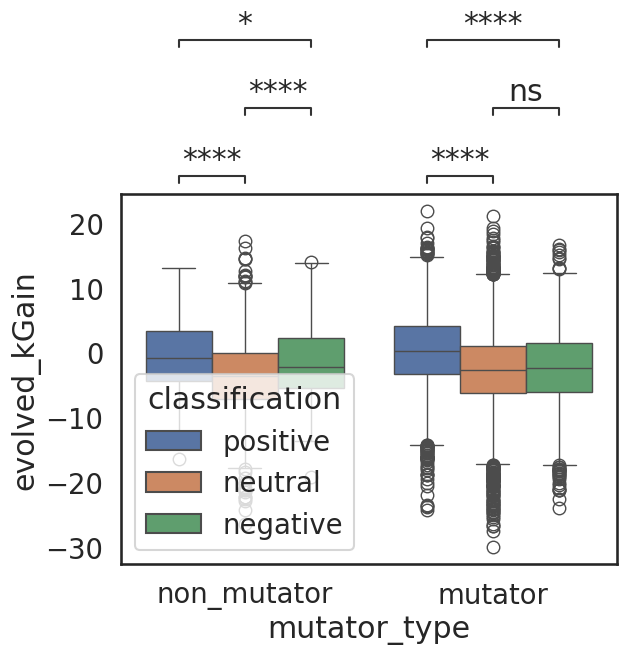

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from scipy import stats

# Define the pairs for comparison
pairs = [
    (("non_mutator", "positive"), ("non_mutator", "neutral")),
    (("non_mutator", "positive"), ("non_mutator", "negative")),
    (("non_mutator", "negative"), ("non_mutator", "neutral")),
    (("mutator", "positive"), ("mutator", "neutral")),
    (("mutator", "positive"), ("mutator", "negative")),
    (("mutator", "neutral"), ("mutator", "negative")),
]
ax = sns.boxplot(data=annotated_mutations_df[["mutator_type", "evolved_kGain", "classification"]].dropna(), x="mutator_type", y="evolved_kGain", hue="classification")

# Compute custom one-sided p-values
pvalues = []
for (g1, g2) in pairs:
    vals1 = annotated_mutations_df[(annotated_mutations_df["mutator_type"] == g1[0]) & (annotated_mutations_df["classification"] == g1[1])]["evolved_kGain"]
    vals2 = annotated_mutations_df[(annotated_mutations_df["mutator_type"] == g2[0]) & (annotated_mutations_df["classification"] == g2[1])]["evolved_kGain"]
    stat, p = mannwhitneyu(vals1, vals2, alternative='greater', nan_policy = "omit")  # one-sided
    pvalues.append(p)
    d_value = utility.median_based_distance(vals1, vals2)
    print(f"P-value = {p:.2e} and and effect size = {d_value:.2e} for {g1[1]} vs {g2[1]} in {g1[0]}")

annotator = Annotator(ax, pairs, data=annotated_mutations_df, x="mutator_type", y="evolved_kGain", hue="classification")
annotator.configure(test=None, text_format='star', loc='outside')
annotator.set_pvalues(pvalues)
annotator.annotate()
plt.show()

##### Fig. 2j

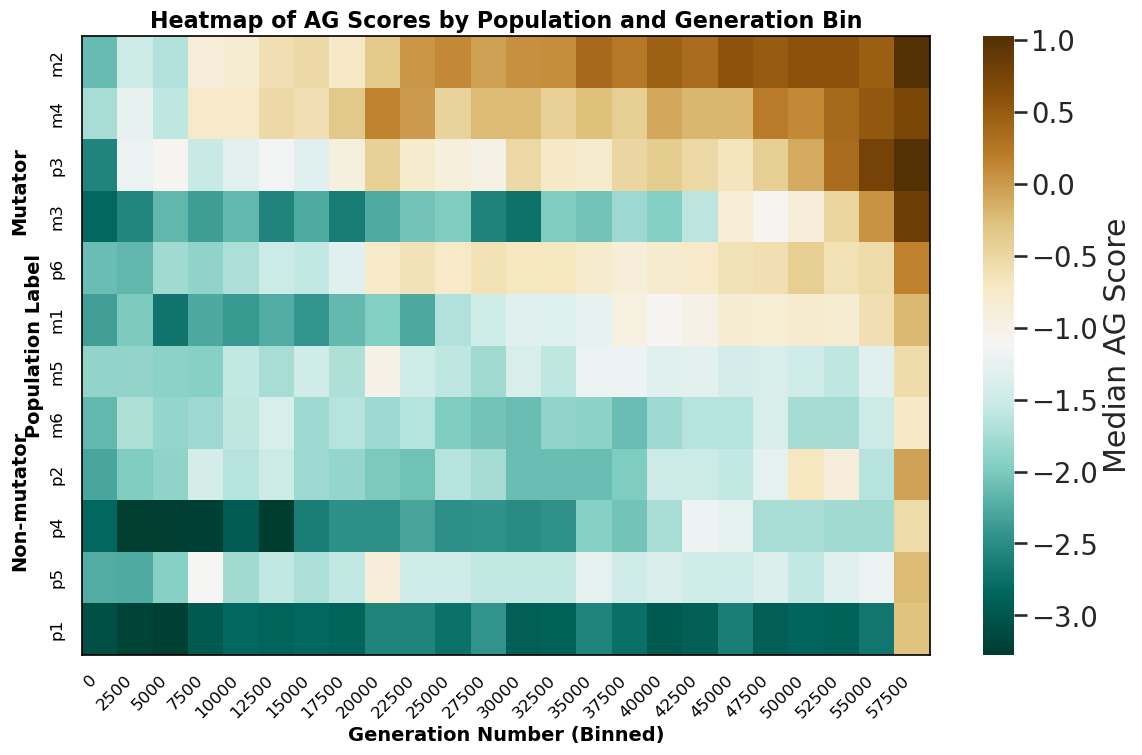

In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Assuming final2 is already defined
df = mutation_with_essentiality_df_with_allele_frequency.copy()

# Bin generations
bin_size = 2500
df['gen_bin'] = (df['generation_number'] // bin_size) * bin_size

# Pivot table
pivot_table = df.pivot_table(
    index='population_label',
    columns='gen_bin',
    values='evolved_kGain',
    aggfunc='median'
).fillna(0)

# Separate mutator and non-mutator labels
mutator_labels = df[df['mutator_type'] == 'mutator']['population_label'].unique()
non_mutator_labels = df[df['mutator_type'] == 'non_mutator']['population_label'].unique()

# Reorder index: mutator first, then non-mutator
ordered_labels = list(mutator_labels) + list(non_mutator_labels)
ordered_labels = ["m2", "m4", "p3", "m3", "p6", "m1", "m5", "m6", "p2", "p4", "p5", "p1"]




pivot_table = pivot_table.loc[pivot_table.index.intersection(ordered_labels)]
pivot_table = pivot_table.reindex(ordered_labels)

# Publication style plotting
plt.figure(figsize=(12, 8))

# Use a clean white background with no grid
sns.set(style="white", context="talk", font_scale=1.2)

# Vibrant complementary colormap, e.g. 'Spectral_r' or 'coolwarm'
cmap_choice = 'BrBG_r'

ax = sns.heatmap(
    pivot_table,
    cmap=cmap_choice,
    linewidths=0,
    linecolor='none',
    cbar_kws={'label': 'Median AG Score'},
    xticklabels=True,
    yticklabels=True
)

# Remove grid lines by setting line widths and removing ticks' minor gridlines
ax.grid(False)

# Make axis lines black and visible
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.2)

# Set axis label and title font properties for publication
ax.set_xlabel('Generation Number (Binned)', fontsize=14, fontweight='bold', color='black')
ax.set_ylabel('Population Label', fontsize=14, fontweight='bold', color='black')
ax.set_title('Heatmap of AG Scores by Population and Generation Bin', fontsize=16, fontweight='bold', color='black')

# X-axis ticks rotation and color
plt.xticks(rotation=45, ha='right', fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')

# Section labels for Mutator and Non-mutator
mutator_end = len(mutator_labels)
ax.text(
    -1.5, mutator_end / 2, 'Mutator', va='center', ha='right',
    fontsize=14, fontweight='bold', color='black', rotation=90
)
ax.text(
    -1.5, mutator_end + len(non_mutator_labels) / 2, 'Non-mutator', va='center', ha='right',
    fontsize=14, fontweight='bold', color='black', rotation=90
)

plt.tight_layout()

# # Save to PDF with 300 dpi locally
# output_pdf_path = "heatmap_AG_scores_publication.pdf"
# with PdfPages(output_pdf_path) as pdf:
#     pdf.savefig(dpi=300)
#     # Show the plot interactively
#     plt.show()
#     plt.close()

# print(f"Heatmap saved as PDF: {output_pdf_path}")


##### Fig. 2k-l

In [148]:
import statsmodels.api as sm

# --- Feature engineering ---
def is_at_to_gc_transition(row):
    """Return 1 if mutation changes A/T to G/C, else 0."""
    return int((row['REF'] in ['A', 'T']) and (row['ALT'] in ['G', 'C']))

annotated_mutations_df['is_AT_to_GC'] = annotated_mutations_df.apply(is_at_to_gc_transition, axis=1)

def classify_neutral_vs_beneficial(class_status):
    """Classify mutations into neutral (0) vs beneficial (1)."""
    class_status = str(class_status).lower()
    if ('negative' in class_status) or ('neutral' in class_status):
        return 'neutral'
    elif 'positive' in class_status:
        return 'beneficial'
    else:
        return 'neutral'  # default fallback

annotated_mutations_df['neutral_vs_beneficial'] = \
    annotated_mutations_df['classification'].apply(classify_neutral_vs_beneficial)

# Encode as binary (neutral=0, beneficial=1)
annotated_mutations_df['neutral_vs_beneficial_encoded'] = \
    annotated_mutations_df['neutral_vs_beneficial'].map({'neutral': 0, 'beneficial': 1})

# --- Define features & target ---
features = annotated_mutations_df[['evolved_kGain', 'is_AT_to_GC']]
target = annotated_mutations_df['neutral_vs_beneficial_encoded']

# Add intercept
features = sm.add_constant(features)

# --- Fit logistic regression ---
logit_model = sm.Logit(target, features)
logit_result = logit_model.fit()

# --- Summary ---
print(logit_result.summary())


Optimization terminated successfully.
         Current function value: 0.541529
         Iterations 6
                                 Logit Regression Results                                
Dep. Variable:     neutral_vs_beneficial_encoded   No. Observations:                36922
Model:                                     Logit   Df Residuals:                    36919
Method:                                      MLE   Df Model:                            2
Date:                           Thu, 31 Jul 2025   Pseudo R-squ.:                 0.04664
Time:                                   16:12:56   Log-Likelihood:                -19994.
converged:                                  True   LL-Null:                       -20972.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         

mutation_class    AT->GC  Other
population_label               
m1                  4214    780
m2                  1620   1778
m3                  1234   1981
m4                  2475   2478
p3                  2938   3029
p6                  9978   1279


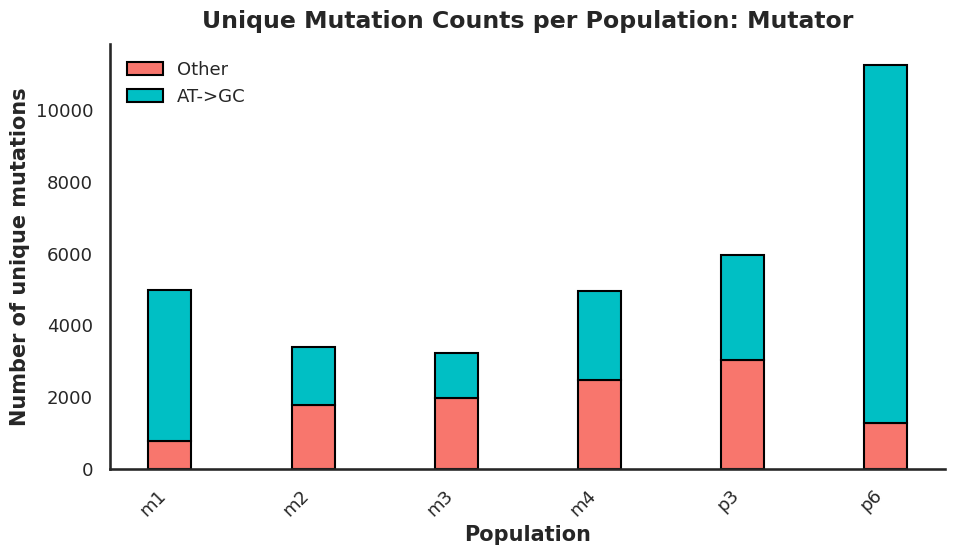

mutation_class    AT->GC  Other
population_label               
m5                   231    369
m6                   139    336
p1                   412    545
p2                   121    210
p4                   157    263
p5                   137    218


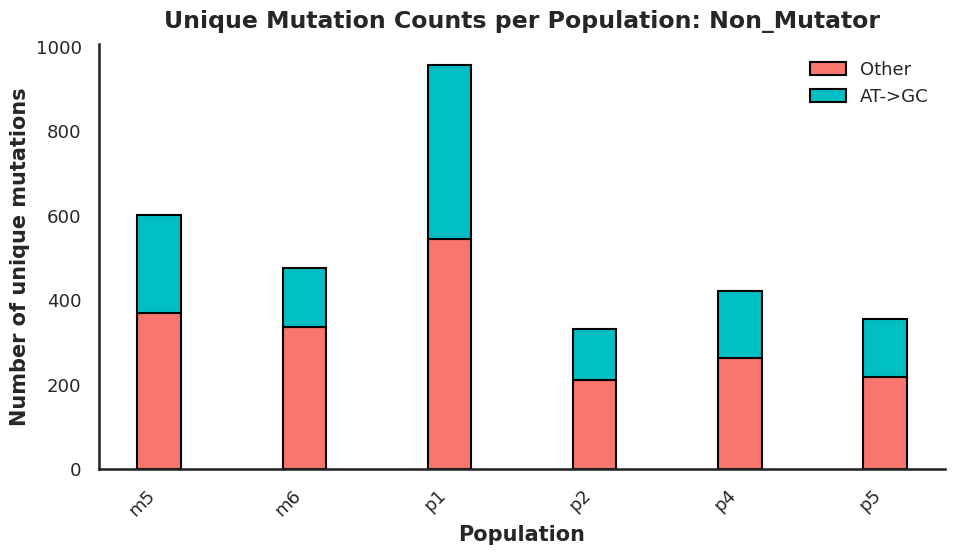

In [149]:

color_atgc = '#00BFC4'
color_other = '#F8766D'

annotated_mutations_df['mutation_class'] = annotated_mutations_df['is_AT_to_GC'].map({1: 'AT->GC', 0: 'Other'})


for mutator_status in ['mutator', 'non_mutator']:
    sub = annotated_mutations_df[annotated_mutations_df['mutator_type'] == mutator_status]
    summary = sub.groupby(['population_label', 'mutation_class']).size().unstack(fill_value=0)
    print(summary)
    # for col in ['AT->GC', 'Other']:
    #     if col not in summary.columns:
    #         summary[col] = 0
    summary = summary[['AT->GC', 'Other']]
    summary = summary.reset_index()
    

    labels = summary['population_label']
    atgc_counts = summary['AT->GC']
    other_counts = summary['Other']

    x = np.arange(len(labels))
    width = 0.3  # slimmer bars 

    plt.figure(figsize=(10,6))
    plt.bar(x, other_counts, width=width, label='Other', color=color_other, edgecolor='black')
    plt.bar(x, atgc_counts, width=width, bottom=other_counts, label='AT->GC', color=color_atgc, edgecolor='black')

    plt.xticks(x, labels, rotation=45, ha='right', fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Number of unique mutations', fontsize=15, fontweight='bold')
    plt.xlabel('Population', fontsize=15, fontweight='bold')
    plt.title(f'Unique Mutation Counts per Population: {mutator_status.title()}', fontsize=17, fontweight='bold', pad=12)
    plt.legend(frameon=False, fontsize=13, title_fontsize=14)
    sns.despine()
    plt.tight_layout()

    # plt.savefig(f'unique_mutation_counts_{mutator_status}.pdf', dpi=300, format='pdf', bbox_inches='tight')
    plt.show()


##### Fig. 2m

/tmp/ipykernel_99464/817590543.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


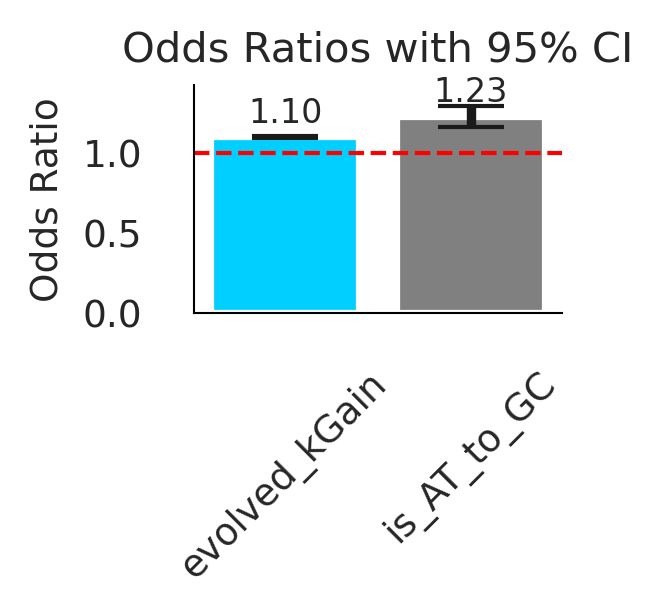

In [150]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), constrained_layout=True, dpi = 300)

# Extract parameters and confidence intervals, excluding intercept
params = logit_result.params.drop('const')
conf = logit_result.conf_int().drop('const')

# Calculate odds ratios and confidence intervals
odds_ratios = np.exp(params)
conf_lower = np.exp(conf[0])
conf_upper = np.exp(conf[1])

# Calculate error bars
error_lower = odds_ratios - conf_lower
error_upper = conf_upper - odds_ratios
error = [error_lower, error_upper]

# Plot
# plt.figure(figsize=(6, 5))
# bars = plt.bar(params.index, odds_ratios, yerr=error, capsize=8, color=['#00CFFF', 'grey'])
bars = ax.bar(params.index, odds_ratios, yerr=error, capsize=8, color=['#00CFFF', 'grey'])
ax.axhline(y=1, color='red', linestyle='--', linewidth=1)

# plt.axhline(y=1, color='red', linestyle='--', linewidth=1)  # Reference line for no effect
ax.set_ylabel('Odds Ratio')
ax.set_title('Odds Ratios with 95% CI', fontsize = 10)
ax.set_ylim(0, max(conf_upper)*1.1)
# Annotate bars
for bar, or_val in zip(bars, odds_ratios):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2,
            height + 0.05,
            f'{or_val:.2f}',
            ha='center', va='bottom', fontsize=8)

# # Optional: annotate bars with OR values
# for bar, or_val in zip(bars, odds_ratios):
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{or_val:.2f}', ha='center', va='bottom', fontsize=12)
ax = utility.custom_figure_axis(ax=ax, fontsize=9, rotation = 45)

plt.tight_layout()
plt.savefig("log_odds.pdf", dpi = 300)